<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

Note to future self: everything is called "James Bay" but we're actually looking at UvicSci (I just copied assignment 5).

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
from scipy import signal
from datetime import timedelta, datetime
import warnings
from IPython.display import display, Math
warnings.filterwarnings('ignore')
hour = 3600
mint = 60

# Getting the Data

In [3]:
def matlab_to_python_datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

## Importing Minute Resolution Data

Now we import the minute resolution data, which only contains data from the one UvicSci temperature data station. We begin by getting the time information, which contains the the start and end time, and the number of measurements taken.

In [4]:
time_info = np.genfromtxt('UvicSci_temperature.dat', delimiter=" ", max_rows=3)
t0 = time_info[0]
tf = time_info[1]
N = time_info[2]

Since the time between measurements is always one minute, we can generate an array of times of measurements based on the information above.

In [5]:
incrementer = (tf-t0)/N
timearray = np.arange(t0, tf, incrementer)

We now open  the actual temperature data, and create a dataframe using the appropriate timestamps.

In [6]:
df_james = pd.read_csv('UvicSci_temperature.dat', sep=" ", skiprows=[0,1,2], names=['Temperature'])
df_james.index = [matlab_to_python_datetime(i) for i in timearray]
df_james.index = [i - timedelta(hours = 7) for i in df_james.index] #Convert to PST

## Obtain Summer and Winter Data

These specify the time boundaries of summer data and winter data.

In [7]:
lower_1 = pd.Timestamp(year=2016, month=6, day=1, hour=0) #summer
upper_1 = pd.Timestamp(year=2016, month=9, day=1, hour=23)
lower_2 = pd.Timestamp(year=2015, month=12, day=1, hour=0) #winter
upper_2 = pd.Timestamp(year=2016, month=3, day=1, hour=23)

Obtain the summer and winter data.

In [8]:
data_james1 = df_james[(df_james.index>lower_1) & (df_james.index<upper_1)]
data_james2 = df_james[(df_james.index>lower_2) & (df_james.index<upper_2)]

Convert the data into numpy arrays.

In [9]:
data_james1 = data_james1.fillna(method='ffill')
data_james2 = data_james2.fillna(method='ffill')
james1 = np.array(data_james1['Temperature']); t_james1 = np.array(data_james1.index)
james2 = np.array(data_james2['Temperature']); t_james2 = np.array(data_james2.index); 

Also convert the removed James Bay Data:

# Design the Filter

In [28]:
def ellip_bandpass(lowcut, highcut, fs, rp, rs, order=5, btype='bandpass'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if (btype == 'bandpass'):
        b, a = sp.signal.ellip(order, rp, rs, [low, high], btype=btype)
    if (btype == 'lowpass'):
        b, a = sp.signal.ellip(order, rp, rs, low, btype=btype)
    if (btype == 'highpass'):
        b, a = sp.signal.ellip(order, rp, rs, high, btype=btype)
        
    return b, a

def ellip_bandpass_filter(data, value, diff_low, diff_high, fs, rp, rs, order=5):
    
    #filter high signals
    b, a = ellip_bandpass(value+diff_low, value+diff_high, fs, rp, rs, order=order, btype='lowpass')
    y = signal.filtfilt(b, a, data)
    
    #filter low signals
    b, a = ellip_bandpass(value-diff_high, value-diff_low, fs, rp, rs, order=order, btype='highpass')
    y = signal.filtfilt(b, a, y)
    
    return y*scale

# Part 1

Get the properties of our filter, and filter for the diurnal band.

In [29]:
diff_low = 0.15/(24*hour)
diff_high = 0.3/(24*hour)

In [30]:
b, a = ellip_bandpass(1/(24*hour)-diff_high, 1/(24*hour)-diff_low, (1/mint), 2, 50, order=3, btype='highpass')
w_high, h_high = signal.freqz(b, a, 100000)

b, a = ellip_bandpass(1/(24*hour)+diff_low, 1/(24*hour)+diff_high, (1/mint), 2, 50, order=3, btype='lowpass')
w_low, h_low = signal.freqz(b, a, 100000)

scale = 1/np.max(abs(h_low*h_high))

Plot frequency response by scaling by the nyquist frequency. The various curves on the plot are explained below:

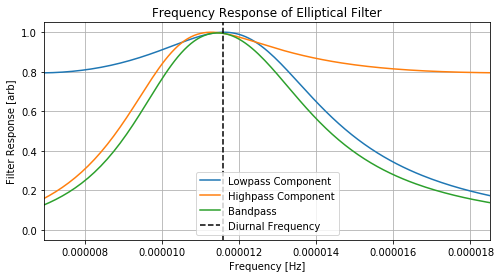

In [31]:
fs=0.5*(1/mint)

fig, ax = plt.subplots(figsize=(8,4))

ax.plot((fs / np.pi) * w_low, abs(h_low), label='Lowpass Component')
ax.plot((fs / np.pi) * w_high, abs(h_high), label='Highpass Component')
ax.plot((fs / np.pi) * w_low, abs(h_low*h_high), label='Bandpass')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Filter Response [arb]')
ax.set_title('Frequency Response of Elliptical Filter')

ax.set_xlim(1/(40*hour), (1/(15*hour)))
ax.axvline(1/(24*hour), color='k', linestyle='--', label=('Diurnal Frequency'))

ax.grid()
ax.legend()

plt.show()

The lowpass and highpass components (blue and orange lines) are used to contruct the bandpass (green line) component.

We then get the red curve, which is the true filter used.

# Part 2

## Part A

Start with James Bay. First filter the data:

In [32]:
james1_filt = ellip_bandpass_filter(james1, value=1/(24*hour), diff_low=diff_low, diff_high=diff_high,
                          fs=1/mint, rp=2, rs=50, order=3)

james2_filt = ellip_bandpass_filter(james2, value=1/(24*hour), diff_low=diff_low, diff_high=diff_high,
                          fs=1/mint, rp=2, rs=50, order=3)

Then plot:

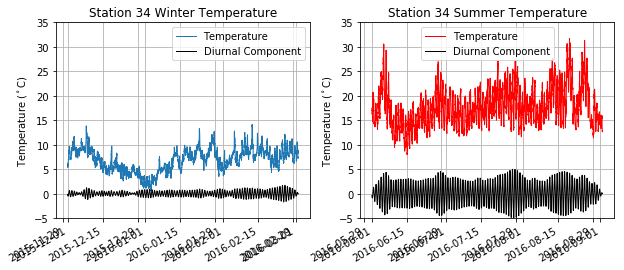

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(t_james2, james2, label='Temperature', lw=1)
ax[0].plot(t_james2, james2_filt, label='Diurnal Component', lw=1, color='k')

ax[1].plot(t_james1, james1, label='Temperature', lw=1, color='r')
ax[1].plot(t_james1, james1_filt, label='Diurnal Component', lw=1, color='k')

ax[0].set_ylim(-5, 35)
ax[1].set_ylim(-5, 35)

ax[0].set_title('Station 34 Winter Temperature')
ax[1].set_title('Station 34 Summer Temperature')

ax[0].set_ylabel('Temperature ($^\circ$C)')
ax[1].set_ylabel('Temperature ($^\circ$C)')

ax[0].grid()
ax[1].grid()

ax[0].legend()
ax[1].legend()

fig.autofmt_xdate()

plt.savefig('plots/stat34_diurnal.png', dpi=300)

## Part B

**Note that all variance measurements are in units of** $(^\circ C)^2$

###  Summer

In [34]:
print('The variance of the time series was {:.2f}'.format(np.var(james1)) +
      ' and the variance of the diurnal band was {:.2f}'.format(np.var(james1_filt)))

The variance of the time series was 14.93 and the variance of the diurnal band was 5.54


###  Winter

In [35]:
print('The variance of the time series was {:.2f}'.format(np.var(james2)) +
      ' and the variance of the diurnal band was {:.2f}'.format(np.var(james2_filt)))

The variance of the time series was 5.33 and the variance of the diurnal band was 0.34


### Summer

In [36]:
print('The perentage of variance in the diurnal band is {:.2f}%'.format(100*np.var(james1_filt)/np.var(james1)))

The perentage of variance in the diurnal band is 37.10%


###  Winter

In [37]:
print('The perentage of variance in the diurnal band is {:.2f}%'.format(100*np.var(james2_filt)/np.var(james2)))

The perentage of variance in the diurnal band is 6.35%
